# An Approach towards solving the task of Image Question Answering

# Importing Useful Libraries

In [1]:
import os
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image as kimage
from keras.layers import Flatten, Dropout, Dense, Input
from keras import Model

#using LSTM from keras for question encoding.
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Concatenate, Dropout
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


# Data Exploration

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
img=mpimg.imread('DE1.png')
img1=mpimg.imread('DE2.png')

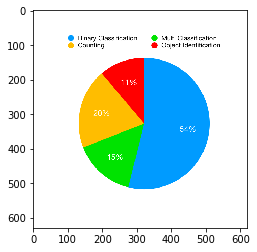

In [4]:
imgplot = plt.imshow(img)

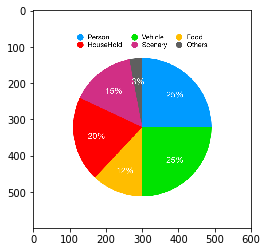

In [5]:
imgplot = plt.imshow(img1)

# Pre-Processing Question Features..............

# Creating a Vocabulary................

In [6]:
import string
from collections import Counter, defaultdict 

def preprocess_triple_file(filepath):
    # useful metadata:
    # vocabulary, longest_sentence_length
    
    # vocabulary for each file
    metadata = {
        'questions': {'vocab': Counter(), 'max_len': 0},
        'answers': {'vocab': Counter(), 'max_len': 0},
        'contexts': {'vocab': Counter(), 'max_len': 0},
    }
    
    # split the file into three parallel text files:
    files = {
        'questions': open(filepath+'.questions', 'w'),
        'answers'  : open(filepath+'.answers', 'w'),
        'contexts' : open(filepath+'.contexts', 'w'),
    }
    
    def process(s, mask_numbers=True, metadata=None):
        def is_number(s):
            try:
                float(s)
                return True
            except ValueError:
                return False
        
        word_sequence = [w.strip().rstrip(string.punctuation) for w in s.split()]
        
        if mask_numbers:
            word_sequence = ['<num>' if mask_numbers and is_number(w) else w for w in word_sequence]

        metadata['vocab'].update(word_sequence)
        metadata['max_len'] = max(len(word_sequence), metadata['max_len'])

        return ' '.join(word_sequence)
    
    
    # stateful reading of the file, each line changes the states as follwing:
    # question => answer => context => question
    state = 'questions'
    for line in open(filepath, encoding='utf-8'):
        files[state].write(process(line, metadata=metadata[state])+'\n')
        
        if state == 'questions':
            state = 'answers'
        elif state == 'answers':
            state = 'contexts'
        elif state == 'contexts':
            state = 'questions'
        
    for state in files:
        files[state].close()

    np.save(filepath+'.metadata.npy', metadata)
    return None

# process these files and produce new files:

preprocess_triple_file("...")
preprocess_triple_file("...")


In [7]:
metadata = np.load('....metadata.npy')[None][0]

question_len = metadata['questions']['max_len']
vocab = metadata['questions']['vocab']
# dump the frequencies:
vocab = ['<pad>', '<unk>', '?']+[w for w,f in vocab.items() if f > 1] # don't keep the rare words.
word2index = defaultdict(lambda: 1, zip(vocab, range(len(vocab)))) # this will set <unk> for unknwon words

answers = metadata['answers']['vocab']
answers = ['<unk>']+[w for w,f in answers.items() if f > 1] # don't keep the rare answers.
answer2index = defaultdict(lambda: 0, zip(answers, range(len(answers)))) # this will set <unk> for unknwon words

In [8]:
X_questions = [
    [word2index['<pad>']]*(question_len-len(line.split()))+[word2index[w.strip()] for w in line.split()]+[word2index['?']]
    for line in open('....questions')
]


Y_answers = [
    [answer2index[w.strip()] for w in line.split()]
    for line in open('....answers')
]

# A look at how Question and Answer Vectors would look

In [9]:
X_questions[1]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 8, 9, 1, 2]

In [10]:
Y_answers[1]

[1]

# After Pre-Processing the Question Features, our next task would be to extract the features from Images

# We wil use CNN Architecture, in order to compare the results 

# Extracting Visual Featurs using ResNet-50 Architecture

# RESNET50

In [11]:
#Calling pre-trained model from keras

In [12]:
#input = Input((224,224,3))
pretrained_cnn_model = ResNet50(include_top=False, weights='imagenet')

### Summarizing the RESNET50 model 

In [13]:
pretrained_cnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [14]:
pretrained_cnn_model.output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(2048)])

### Taking a single image, preprocessing it  and extracting its features using the RESNET50 model

In [15]:
image3 = kimage.load_img("image1.jpeg", target_size=[224,224])

image3_array = kimage.img_to_array(image3)

images_array = np.array([
    image3_array,
])
# At this point we suppose that image is prepared as an RGB formated array
# with integer values of 0-255 for each color code.
# we should make sure that the format is matching input format of the pre-trained network.
# (in this case, the following code makes convernt RGB to BGR)
images_ready = preprocess_input(images_array)

In [16]:
images_ready[0]

array([[[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       ...,

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22

In [17]:
vfearues = pretrained_cnn_model.predict(images_ready)
print('the output shape:', vfearues.shape)
image3_features = vfearues[0].flatten()

print('     dtype:', image3_features.dtype)
print(' dimension:', image3_features.shape[0])
print('the vector:', image3_features)

the output shape: (1, 1, 1, 2048)
     dtype: float32
 dimension: 2048
the vector: [0.         0.2317916  0.         ... 0.37886178 0.         0.19548544]


### Creating a function to pre-process and extract image features from the dataset

In [18]:
def img2vec(image_path):
    x = kimage.load_img(image_path, target_size=[224,224])
    x_array = kimage.img_to_array(x)
    xs_array = np.array([x_array,])
    return pretrained_cnn_model.predict(preprocess_input(xs_array)).flatten()



In [19]:
# this code takes time:
X_images = [
    img2vec("{0}.png".format(image_name.strip()))
    for image_name in open('.....contexts') 
]

### Creating the training data to fit in our model

In [20]:
# repeat questions with several answers, and flatten them with one answer:
trainig_data = list(zip(*[(q,i,a) for q, i, a_s in zip(X_questions,X_images,Y_answers) for a in a_s]))

In [21]:
X_train = [np.array(trainig_data[0]), np.array(trainig_data[1])]
Y_train = np.array(trainig_data[2])
visual_vec_len= X_train[1].shape[1]


### An Overview of the Datasets prepared to train the model

In [22]:
print('the number of all possible answers:', len(answers))
print('the size of vocabulary:', len(vocab))
print('the total number of training samples', len(Y_train))


the number of all possible answers: 23
the size of vocabulary: 152
the total number of training samples 435


### Defining the model 

In [23]:
import os
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image as kimage
from keras.layers import Flatten, Dropout, Dense, Input
from keras import Model
#using LSTM from keras for question encoding.
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Concatenate, Dropout, Activation, RepeatVector, Permute
from keras.layers import Input, merge, Lambda, Multiply
from keras.callbacks import EarlyStopping
import keras.backend as K

#using LSTM from keras for question encoding.
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Concatenate, Dropout
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [24]:
input_question = Input([question_len+1,])
input_context = Input([visual_vec_len,])

# learn embedings (size=300 as we chose just now :D)
q_embs = Embedding(len(vocab), 300)(input_question)

# encode the question
attentions = LSTM(300,return_sequences=True)(q_embs)


#attention = Activation('softmax')(attentions)

attention = Dense(1, activation='tanh')(attentions)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(300)(attention)
attention = Permute([2, 1])(attention)

sent_representation = Multiply()([attentions, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(300,))(sent_representation)

mlp_1 = Dense(visual_vec_len, activation='tanh')(sent_representation)

q_composed = Concatenate()([input_context, mlp_1])

mlp_2 = Dropout(0.2)(Dense(visual_vec_len, activation='relu')(q_composed))

final_a = Dense(len(answers), activation='softmax')(mlp_2)

model = Model([input_question, input_context], final_a)
model.summary()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 300)      45600       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 17, 300)      721200      embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 17, 1)        301      

In [25]:
# what is the loss, and how the parameters should be updated:

#you can use it like this
model.compile('adam', 'sparse_categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [26]:
history=model.fit(X_train, Y_train, epochs=100,verbose=1, batch_size=15,callbacks=None)

Epoch 1/100
435/435 [==============================] - 10s 24ms/step - loss: 4.8592 - acc: 0.2184
Epoch 2/100
435/435 [==============================] - 7s 15ms/step - loss: 1.6750 - acc: 0.4207
Epoch 3/100
435/435 [==============================] - 7s 16ms/step - loss: 1.1070 - acc: 0.5563
Epoch 4/100
435/435 [==============================] - 7s 16ms/step - loss: 0.9422 - acc: 0.6092
Epoch 5/100
435/435 [==============================] - 7s 17ms/step - loss: 0.8439 - acc: 0.6253
Epoch 6/100
435/435 [==============================] - 6s 14ms/step - loss: 0.8050 - acc: 0.6851
Epoch 7/100
435/435 [==============================] - 6s 13ms/step - loss: 0.6744 - acc: 0.7126
Epoch 8/100
435/435 [==============================] - 6s 14ms/step - loss: 0.6316 - acc: 0.7356
Epoch 9/100
435/435 [==============================] - 6s 14ms/step - loss: 0.6713 - acc: 0.7310
Epoch 10/100
435/435 [==============================] - 6s 14ms/step - loss: 0.5696 - acc: 0.7586
Epoch 11/100
435/435 [======

### Preparing the test data

In [27]:
X_questions_test = [
    [word2index['<pad>']]*(question_len-len(line.split()))+[word2index[w.strip()] for w in line.split()][:question_len]+[word2index['?']]
    for line in open('....questions')
]

Y_answers_test = [
    [answer2index[w.strip()] for w in line.split()]
    for line in open('....answers')
]

# this code takes time:
X_images_test = [
    img2vec("{0}.png".format(image_name.strip()))
    for image_name in open('...contexts')
]

test_data = list(zip(*[(q,i,a) for q, i, a_s in zip(X_questions_test,X_images_test,Y_answers_test) for a in a_s]))

X_test = [np.array(test_data[0]), np.array(test_data[1])]
Y_test = np.array(test_data[2])
img=[image_name.strip() for image_name in open('...contexts')][0]


### Evaluating on Test Data set

In [28]:
model.evaluate(X_test,Y_test)

260/260 [==============================] - 1s 3ms/step


[6.004068800119254, 0.4153846153846154]

a test question: Is there a person standing in the image ?
the dataset answer: No
the predicted answer: No
image: image7


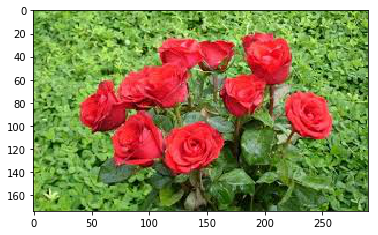

In [31]:
print('a test question:', ' '.join([vocab[wid] for sent in X_test[0][15:16] for wid in sent if wid != 0]))
print('the dataset answer:', ' '.join([answers[wid] for wid in Y_test[15:16] ]))
print('the predicted answer:', answers[np.argmax(model.predict([X_test[0][15:16], X_test[1][15:67]]), 1)[0]])

print('image:', [image_name.strip() for image_name in open('....contexts')][15])
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('image7.png')
imgplot = plt.imshow(img)


# Thank You